In [1]:
from itertools import combinations

import mysql.connector as sql
import numpy as np
import pandas as pd
import scikit_posthocs as sp
import seaborn as sns
from bootstrap import bootstrap_error_estimate
from scipy.stats import gmean
# Model comparison imports
from delong_ci import calc_auc_ci
from mlxtend.evaluate import cochrans_q, mcnemar, mcnemar_table
from mlxtend.evaluate import paired_ttest_5x2cv
#RDKit imports
from rdkit import Chem
from rdkit import Chem
from rdkit.Chem import AllChem
# ML imports
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

Establish a connection to a local version of the ChEMBL database. 

In [2]:
con = sql.connect(host='localhost', database='chembl_26', user='pwalters', password='relayrelay')
cursor = con.cursor()

Query the ChEMBL database for hERG data. 

In [3]:
query = """select canonical_smiles, cs.molregno, md.chembl_id as mol_chembl_id, standard_relation, standard_value,
standard_type, standard_units, description, td.organism, assay_type, confidence_score,
td.pref_name, td.chembl_id as tgt_chembl_id
from activities act
join assays ass on act.assay_id = ass.assay_id
join target_dictionary td on td.tid = ass.tid
join compound_structures cs on cs.molregno = act.molregno
join molecule_dictionary md on md.molregno = cs.molregno
where ass.tid = 165
and assay_type in ('B','F')
and standard_value is not null
and standard_units = 'nM'
and act.standard_relation is not null
and standard_type = 'IC50'
and standard_relation = '='"""

In [4]:
df_ok = pd.read_sql(query,con=con)

A quick sanity check to ensure that we extracted the data correctly. 

In [5]:
df_ok.head()

,canonical_smiles,molregno,mol_chembl_id,standard_relation,standard_value,standard_type,standard_units,description,organism,assay_type,confidence_score,pref_name,tgt_chembl_id
0,COCC(=O)O[C@]1(CCN(C)CCCc2nc3ccccc3[nH]2)CCc2c...,72035,CHEMBL45816,=,1430.0,IC50,nM,K+ channel blocking activity in COS-7 African ...,Homo sapiens,F,8,HERG,CHEMBL240
1,CC(C)COCC(CN(Cc1ccccc1)c1ccccc1)N1CCCC1,112651,CHEMBL1008,=,550.0,IC50,nM,K+ channel blocking activity in COS-7 African ...,Homo sapiens,F,9,HERG,CHEMBL240
2,COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(...,1788,CHEMBL32,=,129000.0,IC50,nM,K+ channel blocking activity in Chinese hamste...,Homo sapiens,F,8,HERG,CHEMBL240
3,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,1712,CHEMBL31,=,130000.0,IC50,nM,K+ channel blocking activity in Chinese hamste...,Homo sapiens,F,8,HERG,CHEMBL240
4,Cc1c(F)c(N2CCNC(C)C2)cc2c1c(=O)c(C(=O)O)cn2C1CC1,17136,CHEMBL583,=,104000.0,IC50,nM,K+ channel blocking activity in Chinese hamste...,Homo sapiens,F,8,HERG,CHEMBL240


Aggregate the results by taking the geometric mean of replicates. 

In [6]:
grouper =  df_ok.groupby(["canonical_smiles","molregno"])
data_df = grouper['standard_value'].apply(gmean).to_frame(name = 'IC50').reset_index()

Add a new column with the pIC50

In [7]:
data_df['pIC50'] = -np.log10(data_df.IC50*1e-9)

Set the "Active" field to 1 if the pIC50 >= 5 (10uM), otherwise 0

Look at counts of active and inactive molecules

In [8]:
data_df['Active'] = [1 if x >= 5 else 0 for x in data_df.pIC50]
data_df['Active'].value_counts()

1    4191
0    2048
Name: Active, dtype: int64

Visualize the activity distribution.

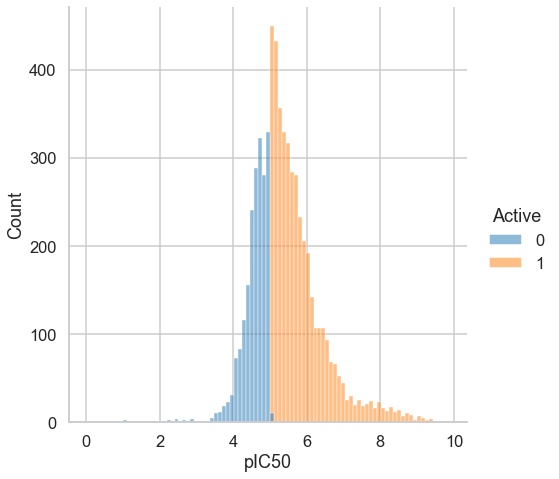

In [9]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.displot(data=data_df,x='pIC50',hue='Active',height=7);

Define a function to get a Morgan fingerprint from a SMILES string

In [10]:
def gen_fp(smi):
    mol = Chem.MolFromSmiles(smi)
    fp = None
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2)
    return fp

Enable the "progress_apply" function that lets us use a progress bar.

In [11]:
tqdm.pandas()

In [12]:
data_df['fp'] = data_df.canonical_smiles.progress_apply(gen_fp)

  0%|          | 0/6239 [00:00<?, ?it/s]

Remove rows where we didn't successfully generate a fingerprint.

In [13]:
num_orig_rows = len(data_df)
data_df.dropna(inplace=True)
num_filtered_rows = len(data_df)
num_orig_rows, num_filtered_rows

(6239, 6239)

Build a quick ML model as a test. 

In [14]:
train, test = train_test_split(data_df)
train_X = np.stack(train.fp)
train_y = train.Active.values
test_X = np.stack(test.fp)
test_Y = test.Active.values
lgbm = LGBMClassifier()
lgbm.fit(train_X,train_y)
pred = lgbm.predict(test_X)
auc = roc_auc_score(test_Y,pred)
auc

0.6942914297901759

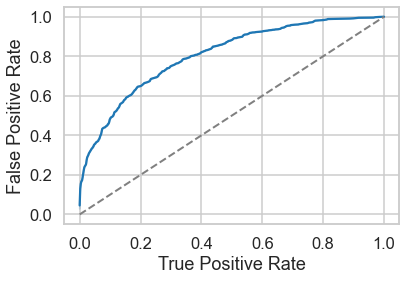

In [15]:
prob = lgbm.predict_proba(test_X)[:,1]
false_pos_rate, true_pos_rate, thresholds = roc_curve(test_Y,prob)
ax = sns.lineplot(x=false_pos_rate,y=true_pos_rate)
ax.set_xlabel("True Positive Rate")
ax.set_ylabel("False Positive Rate")
# add the unity line
linemin = 0
linemax = 1
ax.plot([linemin,linemax],[linemin,linemax],color="grey",linewidth=2,linestyle="--");

For 10 folds of cross-validation loop over the different model types, train and test models. 

In [16]:
method_list = [KNeighborsClassifier, RandomForestClassifier, LGBMClassifier]
method_name_list = [x().__class__.__name__ for x in method_list]
method_name_list = [x.replace("Classifier","") for x in method_name_list]
truth_list = []
pred_list = []
prob_list = []
cv_cycles = 10
for i in tqdm(range(0,cv_cycles)):
    train, test = train_test_split(data_df)
    train_X = np.stack(train.fp)
    train_y = train.Active.values
    test_X = np.stack(test.fp)
    test_y = test.Active.values
    cycle_pred = []
    cycle_prob = []
    for method, method_name in zip(method_list, method_name_list):
        if method_name == "XGB":
            cls = method(use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
        else:
            cls = method(n_jobs=-1)
        cls.fit(train_X, train_y)
        cycle_pred.append(cls.predict(test_X))
        cycle_prob.append(cls.predict_proba(test_X))

    truth_list.append(test.Active.values)        
    pred_list.append(cycle_pred)
    prob_list.append(cycle_prob)

  0%|          | 0/10 [00:00<?, ?it/s]

Build a dataframe with the AUC values collected above. 

In [17]:
auc_result = []
for truth, prob in zip(truth_list,prob_list):
    for name, p in zip(method_name_list, prob):
        auc_result.append([name,roc_auc_score(truth,p[:,1])])
auc_df = pd.DataFrame(auc_result,columns=["Method","AUC"])

Here's what people typically do in the literature.  Construct a bar char with the mean AUC for each of the methods, add a "whisker" to show the standard deviation.  **In my mind this is not a good way to present data**.  It doesn't adequately reflect the performance across cross validation folds and doesn't show whether the differences between methods are statistically significant. 

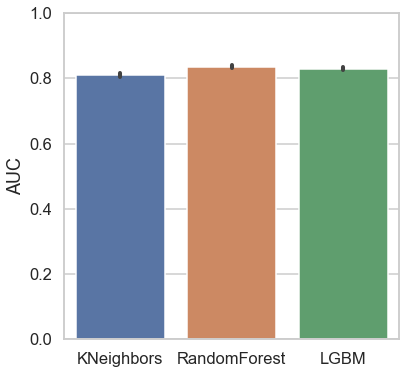

In [18]:
sns.set(rc={'figure.figsize': (6, 6)})
sns.set_style('whitegrid')
sns.set_context('talk')
ax = sns.barplot(x="Method",y="AUC",data=auc_df)
labels = [x.get_text() for x in ax.get_xticklabels()]
ax.set(xticklabels=labels)
ax.set(ylim=[0,1])
_ = ax.set(xlabel="")

Here's a somewhat better approach where we represent the distribution of AUC values as box plots.  This is somewhat better, but we're still not making an adequate comparison between methods. 

<AxesSubplot:xlabel='Method', ylabel='AUC'>

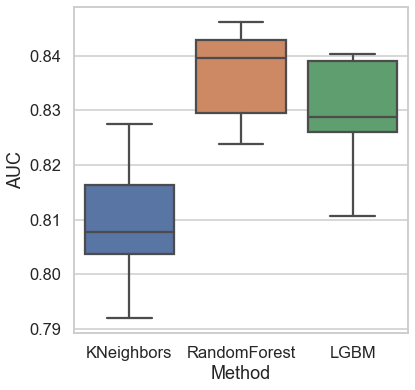

In [19]:
sns.boxplot(x="Method",y="AUC",data=auc_df)

We can calculate a 95% confidence interval around each AUC using [DeLong's method](https://github.com/yandexdataschool/roc_comparison/blob/master/compare_auc_delong_xu.py).  

In [20]:
auc_result = []
for cycle, [truth, prob] in enumerate(zip(truth_list,prob_list)):
    for name, p in zip(method_name_list, prob):
        truth = np.array([int(x) for x in truth])
        auc, (lb, ub) = calc_auc_ci(truth,p[:,1])
        auc_result.append([cycle,name, auc, lb, ub])
auc_ci_df = pd.DataFrame(auc_result,columns=["Cycle","Method","AUC","LB","UB"])
auc_ci_df.head()

,Cycle,Method,AUC,LB,UB
0,0,KNeighbors,0.804346,0.782493,0.826199
1,0,RandomForest,0.840062,0.819991,0.860134
2,0,LGBM,0.838470,0.818640,0.858301
3,1,KNeighbors,0.817292,0.795493,0.839091
4,1,RandomForest,0.846191,0.826062,0.866320


Define a routine for displaying the AUC values and the associated 95% confidence intervals.

In [21]:
def ci_pointplot(input_df, x_col="Cycle", y_col="AUC", hue_col="Method", lb_col="LB", ub_col="UB"):
    dodge_val = 0.25
    palette_name = "deep"
    cv_cycles = len(input_df[x_col].unique())
    ax = sns.pointplot(x=x_col, y=y_col, hue=hue_col, data=input_df, dodge=dodge_val, join=False, palettte=palette_name)
    colors = sns.color_palette(palette_name, len(input_df.Method.unique())) * cv_cycles
    ax.axvline(0.5, ls="--", c="gray")
    for x in np.arange(0.5, cv_cycles, 1):
        ax.axvline(x, ls="--", c="gray")
    y_val = input_df[y_col]
    lb = y_val - input_df[lb_col]
    ub = input_df[ub_col] - y_val
    x_pos = []
    for i in range(0, cv_cycles):
        x_pos += [i - dodge_val / 2, i, i + dodge_val / 2]
    _ = ax.errorbar(x_pos, y_val, yerr=[lb, ub], fmt="none", capsize=0, color=colors)

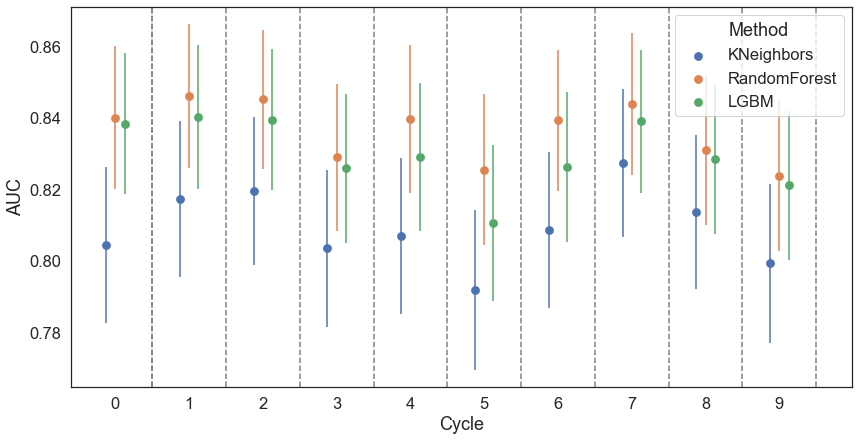

In [22]:
sns.set(rc={'figure.figsize': (14, 7)})
sns.set(font_scale=1.5)
sns.set_style('white')
ci_pointplot(auc_ci_df)

In addition to using an analytic method for calculating confidence intervals, we can also bootstrap an estimate. 

In [23]:
bootstrap_result = []
with tqdm(total=len(truth_list)) as pbar:
    for cycle,[truth,probs] in enumerate(zip(truth_list,prob_list)):
        for name,p in zip(method_name_list,probs):
            auc = roc_auc_score(truth,p[:,1])
            lb,ub = bootstrap_error_estimate(truth,p[:,1],roc_auc_score)
            bootstrap_result.append([cycle,name,auc,lb,ub])
        pbar.update(1)
bootstrap_df = pd.DataFrame(bootstrap_result,columns=["Cycle","Method","AUC","LB","UB"])

  0%|          | 0/10 [00:00<?, ?it/s]

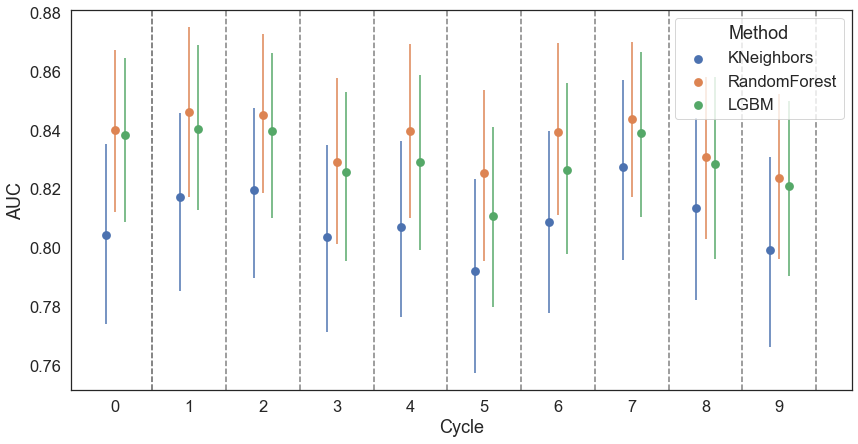

In [24]:
ci_pointplot(bootstrap_df)

[5x2 cross validation](https://sci2s.ugr.es/keel/pdf/algorithm/articulo/dietterich1998.pdf)

In [ ]:
X = np.stack(data_df.fp)
y = data_df.Active.values
classifier_list = []
for method, name in zip(method_list, method_name_list):
    if name == "XGB":
        classifier_list.append(method(use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
    else:
        classifier_list.append(method(n_jobs=-1))
print(f"{'Method_1':12s} {'Method_2':12s} {'p-value'}")
for a,b in combinations(zip(classifier_list,method_name_list),2):
    clf1,name1 = a
    clf2,name2 = b
    t, p = paired_ttest_5x2cv(estimator1=clf1,estimator2=clf2,X=X, y=y, scoring="roc_auc")
    print(f"{name1:12s} {name2:12s} {p:.3f}")

Method_1     Method_2     p-value


McNemar's test

In [ ]:
mc_result = []
for truth, pred in zip(truth_list,pred_list): 
    for i,j in combinations(range(len(method_list)),2):
        mc, mc_pvalue = mcnemar(mcnemar_table(truth, pred[i], pred[j]))
        mc_result.append([method_name_list[i],method_name_list[j], mc_pvalue])
mc_df = pd.DataFrame(mc_result,columns=["Method_1","Method_2","p_value"])
mc_df['Combo'] = mc_df.Method_1 + "_" + mc_df.Method_2
for k,v in mc_df.groupby("Combo"):
    print(k,v.p_value.mean())

In [ ]:
len(mc_result)

In [ ]:
alpha = 0.05/len(pred_list[0])
alpha

In [ ]:
ax = sns.boxplot(x="p_value",y="Combo",data=mc_df)
ax.set(ylabel="",xlabel="p value")
_ = ax.axvline(alpha,c="red",ls="--")